### Advanced usage of recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 3 of Deep Learning with Python. Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

In this section, we will review three advanced techniques for improving the performance and generalization power of recurrent neural networks. By the end of the section, you will know most of what there is to know about using recurrent networks with Keras. We will demonstrate all three concepts on a weather forecasting problem, where we have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries.

We will cover the following techniques:

- Recurrent dropout, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
- Stacking recurrent layers, to increase the representational power of the network (at the cost of higher computational loads).
- Bidirectional recurrent layers, which presents the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

### A temperature forecasting problem
Until now, the only sequence data we have covered has been text data, for instance the IMDB dataset and the Reuters dataset. But sequence data is found in many more problems than just language processing. In all of our examples in this section, we will be playing with a weather timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the air temperature 24 hours in the future.

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import gc

In [2]:
from urllib.request import urlretrieve
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = urlretrieve(url=uri, filename="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path[0])
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

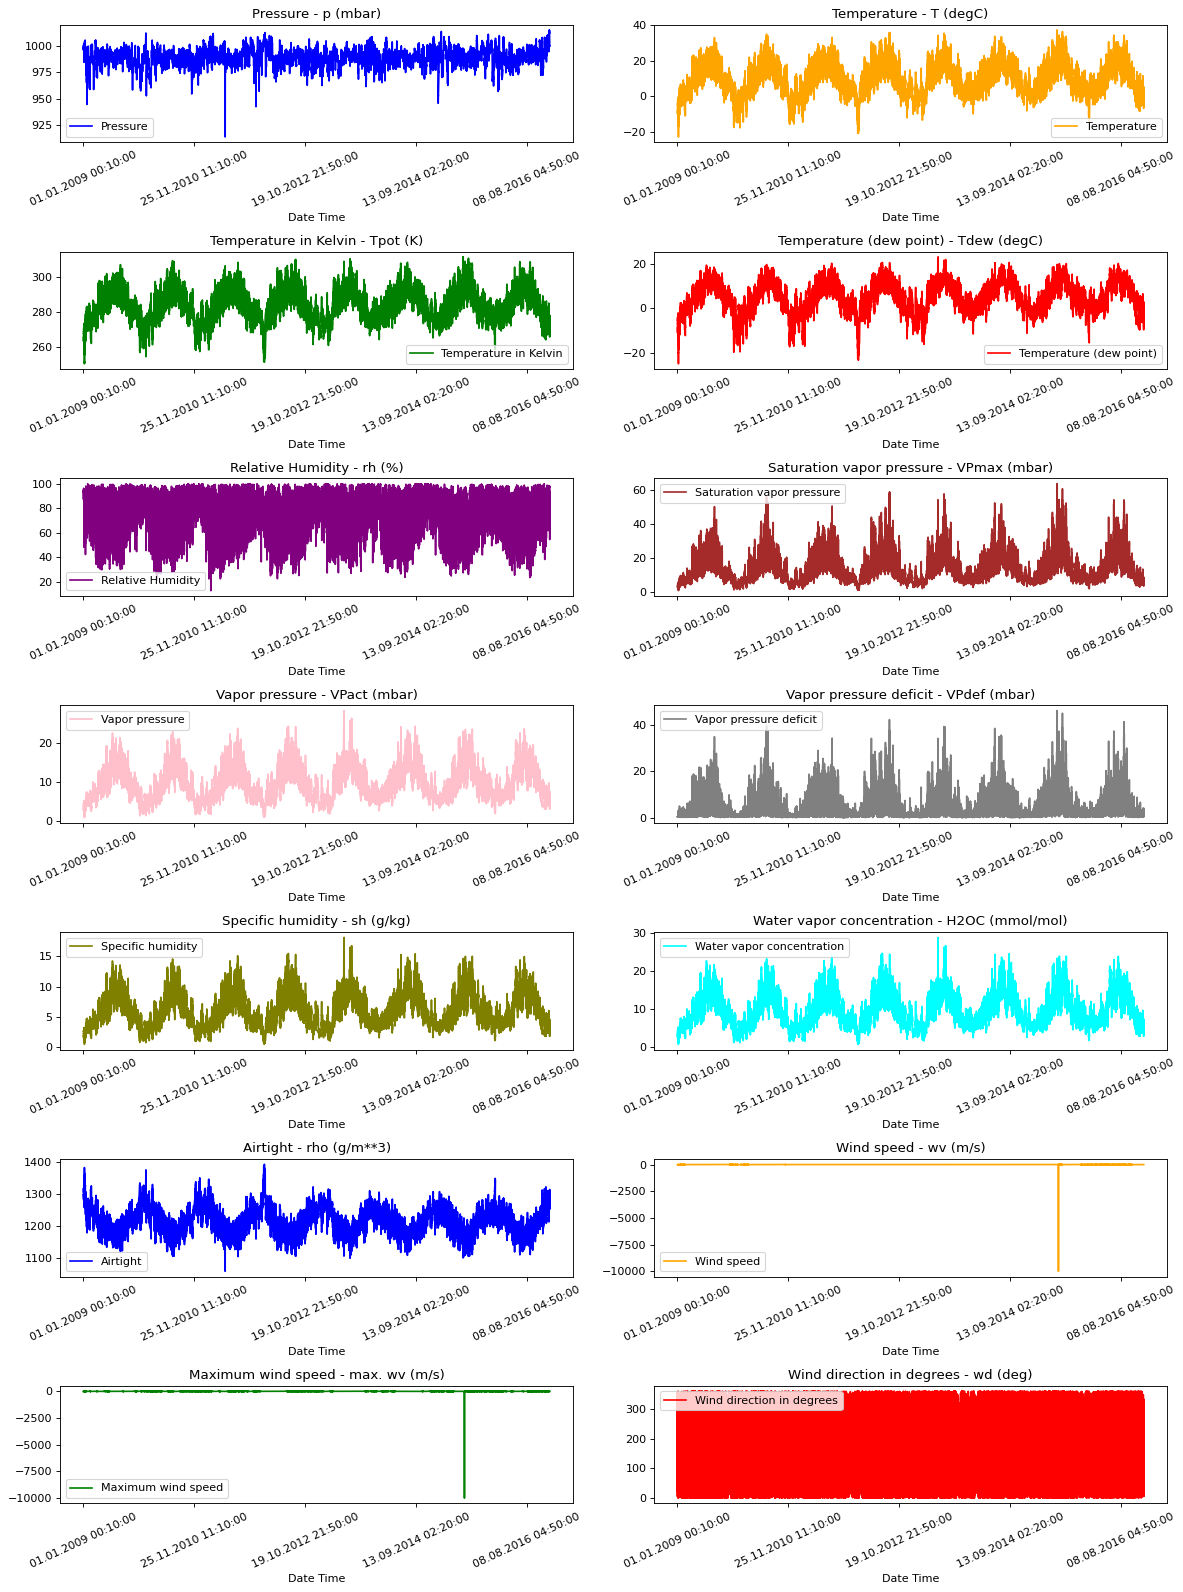

In [3]:
import matplotlib.pyplot as plt

titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

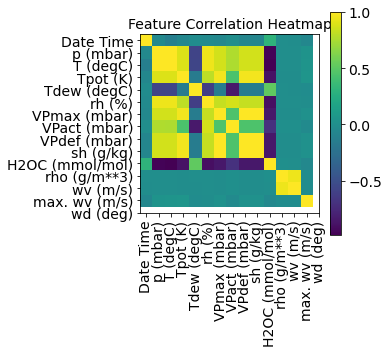

In [4]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

### Preparing the data

The exact formulation of our problem will be the following: given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can we predict the temperature in delay timesteps?

We will use the following parameter values:

- lookback = 720, i.e. our observations will go back 5 days.
- steps = 6, i.e. our observations will be sampled at one data point per hour.
- delay = 144, i.e. our targets will be 24 hours in the future.

To get started, we need to do two things:

- Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a similar scale.
- Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample N and sample N + 1 will have most of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [5]:
from torch.utils.data import Dataset, DataLoader

f = open(csv_path)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]


float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


class dataset(Dataset):
    def __init__(self, data, lookback, delay, min_index, max_index, step=6, inverse_order = False):
        super(dataset).__init__()
        if max_index is None:
            max_index = len(data)
        self.inverse_order = inverse_order

        self.samples = torch.zeros(max_index - min_index+ lookback, lookback // step, data.shape[-1])
        self.targets = torch.zeros(max_index - min_index+ lookback, 1)
            
        for i in range(len(self.samples)):
            indices = range(i - lookback, i, step)
            self.samples[i] = torch.tensor(data[indices]).float()
            self.targets[i] = torch.tensor(data[i + delay][1]).float()
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        samples = self.samples[index]
        targets = self.targets[index]

        if self.inverse_order:
            return samples[:,::-1,:], targets
        else:
            return samples, targets



def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield torch.tensor(samples).float(), torch.tensor(targets).float()

def reverse_order_generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield torch.tensor(samples[:, ::-1, :]).float(), torch.tensor(targets).float()

In [6]:
ori_float_data = float_data

### Util function

In [7]:
def plot_history(history):
    fig = plt.figure(figsize=(10, 5))

    plt.figure()
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print('Max validation mae:', max(history['val_loss']))

def gen_dataset(float_data, lookback, step, delay, batch_size):    
    # train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
    train_data = dataset(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, step=step)
    val_data = dataset(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step)
    test_data = dataset(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step)

    train_data_reverse = dataset(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, step=step, inverse_order=True)
    val_data_reverse = dataset(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, inverse_order=True)
    test_data = dataset(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, inverse_order=True)

    val_steps = (300000 - 200001 - lookback) // batch_size
    test_steps = (len(float_data) - 300001 - lookback) // batch_size

    train_gen = DataLoader(train_data, batch_size, shuffle=True)
    val_gen = DataLoader(train_data, batch_size, shuffle=False)
    test_gen = DataLoader(train_data, batch_size, shuffle=False)

    return float_data, train_gen, val_gen, test_gen, lookback, step

### Trainer

In [8]:
class Trainer(object):
    def __init__(self, train_dataloader, val_dataloader, model, lr, checkname):
        self.lr = lr
        self.checkname = checkname
        
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.model = model
        self.model = self.model.to(self.device)
        
        self.criterion = torch.nn.MSELoss()
        self.eval_metric = torch.nn.L1Loss()
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr = self.lr)
       
        self.checkname = self.checkname
        self.save_root = os.path.join('./ckpts', self.checkname)
        if not os.path.exists(self.save_root):
            os.mkdir(self.save_root)
        self.best_pred = 0
        self.eval_best_loss = 10000000
        self.history = {'loss':[], 'val_loss':[]}

    def training(self, epoch):
        self.model.train()
        self.total_loss = 0
        self.train_acc = 0
        total = 0
        for i, (item) in (enumerate(self.train_dataloader)):
            if len(item) == 3:
                label, data, off = item
                off = off.to(self.device)
            else:
                data, label = item
            data, label = data.to(self.device), label.to(self.device)
            self.optimizer.zero_grad() 
            if len(item) == 2:
                pred = self.model(data) 
            elif len(item) == 3:
                pred = self.model(data, off)
            loss = self.criterion(pred, label)
            loss.backward() 
            self.optimizer.step() 
            self.total_loss += loss 
            
        print('Training loss : %.5f'%(self.total_loss/(i+1)))
        self.history['loss'].append((self.total_loss/(i+1)).cpu().item())
        
        
    def validation(self, epoch):
        self.model.eval() 
        self.val_loss = 0
        self.eval_metric_loss = 0
        self.val_acc = 0
        total = 0 
        for i, (item) in (enumerate(self.val_dataloader)):
            if len(item) == 3:
                label, data, off = item
                off = off.to(self.device)
            else:
                data, label = item  
            data, label = data.to(self.device), label.to(self.device)
            with torch.no_grad():
                if len(item) == 2:
                    pred = self.model(data) 
                elif len(item) == 3:
                    pred = self.model(data, off)
                    
                eval_loss = self.eval_metric(pred, label)
                self.eval_metric_loss += eval_loss 
                    
                loss = self.criterion(pred, label) 
                self.val_loss += loss
           
        print('Validation loss : %.5f'%(self.val_loss/(i+1)))
        print('Validation metric Loss : %.5f'%(self.eval_metric_loss/(i+1)))
        self.history['val_loss'].append((self.val_loss/(i+1)).cpu().item())

        if self.eval_best_loss > self.eval_metric_loss:
            self.eval_best_loss = self.eval_metric_loss
            torch.save(self.model.state_dict(), os.path.join(self.save_root, 'model_best.pth'))

    def evaluate_loader(self, loader):
        self.model.load_state_dict(torch.load(os.path.join(self.save_root, 'model_best.pth')))
        self.model.eval() 
        self.val_loss = 0
        self.eval_metric_loss = 0
        self.val_acc = 0
        total = 0 
        for i, (item) in (enumerate(loader)):
            if len(item) == 3:
                label, data, off = item
                off = off.to(self.device)
            else:
                data, label = item  
            data, label = data.to(self.device), label.to(self.device)
            with torch.no_grad():
                if len(item) == 2:
                    pred = self.model(data) 
                elif len(item) == 3:
                    pred = self.model(data, off)
                    
                eval_loss = self.eval_metric(pred, label)
                self.eval_metric_loss += eval_loss 
                    
                loss = self.criterion(pred, label) 
                self.val_loss += loss
           
        print('Test loss : %.5f'%(self.val_loss/(i+1)))
        print('Test metric Loss (MAE) : %.5f'%(self.eval_metric_loss/(i+1)))

In [9]:
def fit(trainer, epochs):
    trainer.history = {'loss':[], 'val_loss':[]}

    for epoch in range(epochs):
        print('Epoch :', str(epoch))
        trainer.training(epoch) 
        trainer.validation(epoch)
    print('Best prediction (L1 loss) on Validation set :', trainer.eval_best_loss.item())

In [10]:
# Look back: 720 points
_, train_gen720, val_gen720, test_gen720, lookback720, step720 = gen_dataset(ori_float_data, 720, 6, 144, 128)

Epoch : 0
Training loss : 0.28151
Validation loss : 0.18857
Validation metric Loss : 0.34330
Epoch : 1
Training loss : 0.11048
Validation loss : 0.11971
Validation metric Loss : 0.27052
Epoch : 2
Training loss : 0.09577
Validation loss : 0.11038
Validation metric Loss : 0.25877
Epoch : 3
Training loss : 0.08873
Validation loss : 0.09027
Validation metric Loss : 0.23712
Epoch : 4
Training loss : 0.08292
Validation loss : 0.07522
Validation metric Loss : 0.21477
Epoch : 5
Training loss : 0.07946
Validation loss : 0.06633
Validation metric Loss : 0.20323
Epoch : 6
Training loss : 0.07626
Validation loss : 0.08628
Validation metric Loss : 0.23161
Epoch : 7
Training loss : 0.07380
Validation loss : 0.12349
Validation metric Loss : 0.27863
Epoch : 8
Training loss : 0.07152
Validation loss : 0.09768
Validation metric Loss : 0.24538
Epoch : 9
Training loss : 0.06966
Validation loss : 0.08864
Validation metric Loss : 0.23595
Epoch : 10
Training loss : 0.06802
Validation loss : 0.09432
Validatio

<Figure size 720x360 with 0 Axes>

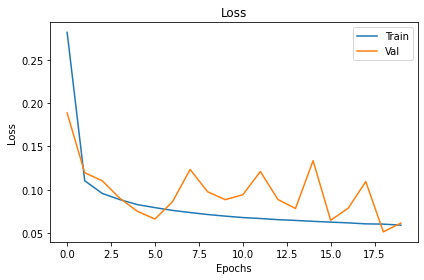

Max validation mae: 0.18857045471668243
Test loss : 0.05156
Test metric Loss (MAE) : 0.17967


In [11]:
import torch.nn as nn

## Simple FCN
class FCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCN, self).__init__()

        self.hidden_size = hidden_size

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act1 = nn.ReLU()        
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act1(self.fc1(x))
        x = self.fc2(x)
        return x

# print(lookback, step, lookback//step)
fcn = FCN(lookback720 // step720 * 14, 32, 1)
fcn_Trainer = Trainer(train_gen720, val_gen720, fcn, 0.001, 'fcn')
fit(fcn_Trainer, 20)

plot_history(fcn_Trainer.history)

fcn_Trainer.evaluate_loader(test_gen720)

Epoch : 0
Training loss : 0.92709
Validation loss : 0.21993
Validation metric Loss : 0.37195
Epoch : 1
Training loss : 0.11126
Validation loss : 0.07314
Validation metric Loss : 0.21296
Epoch : 2
Training loss : 0.08889
Validation loss : 0.08122
Validation metric Loss : 0.22863
Epoch : 3
Training loss : 0.07730
Validation loss : 0.05497
Validation metric Loss : 0.18673
Epoch : 4
Training loss : 0.07125
Validation loss : 0.05128
Validation metric Loss : 0.17913
Epoch : 5
Training loss : 0.06613
Validation loss : 0.08033
Validation metric Loss : 0.22169
Epoch : 6
Training loss : 0.06292
Validation loss : 0.04493
Validation metric Loss : 0.16862
Epoch : 7
Training loss : 0.05988
Validation loss : 0.08758
Validation metric Loss : 0.24226
Epoch : 8
Training loss : 0.05765
Validation loss : 0.04225
Validation metric Loss : 0.16465
Epoch : 9
Training loss : 0.05602
Validation loss : 0.03582
Validation metric Loss : 0.15013
Epoch : 10
Training loss : 0.05421
Validation loss : 0.05965
Validatio

<Figure size 720x360 with 0 Axes>

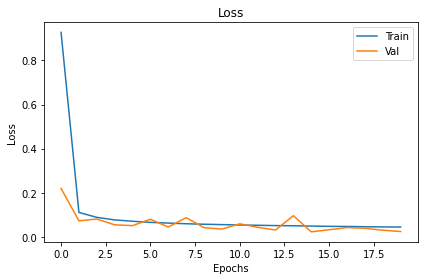

Max validation mae: 0.21993081271648407
Test loss : 0.02329
Test metric Loss (MAE) : 0.11984


In [12]:
# Look back: 1440 points
_, train_gen1440, val_gen1440, test_gen1440, lookback1440, step1440 = gen_dataset(ori_float_data, 1440, 6, 144, 128)

fcn = FCN(lookback1440 // step1440 * 14, 32, 1)
fcn_Trainer = Trainer(train_gen1440, val_gen1440, fcn, 0.001, 'fcn')
fit(fcn_Trainer, 20)

plot_history(fcn_Trainer.history)

fcn_Trainer.evaluate_loader(test_gen1440)

### Simple RNN

Epoch : 0
Training loss : 0.14482
Validation loss : 0.14410
Validation metric Loss : 0.29621
Epoch : 1
Training loss : 0.13276
Validation loss : 0.15369
Validation metric Loss : 0.30804
Epoch : 2
Training loss : 0.12892
Validation loss : 0.13250
Validation metric Loss : 0.28336
Epoch : 3
Training loss : 0.12821
Validation loss : 0.13667
Validation metric Loss : 0.28859
Epoch : 4
Training loss : 0.12453
Validation loss : 0.12752
Validation metric Loss : 0.27951
Epoch : 5
Training loss : 0.12252
Validation loss : 0.12725
Validation metric Loss : 0.27759
Epoch : 6
Training loss : 0.12332
Validation loss : 0.13259
Validation metric Loss : 0.28372
Epoch : 7
Training loss : 0.12049
Validation loss : 0.12083
Validation metric Loss : 0.27206
Epoch : 8
Training loss : 0.12060
Validation loss : 0.12091
Validation metric Loss : 0.27093
Epoch : 9
Training loss : 0.12070
Validation loss : 0.12209
Validation metric Loss : 0.27250
Epoch : 10
Training loss : 0.11974
Validation loss : 0.12326
Validatio

<Figure size 720x360 with 0 Axes>

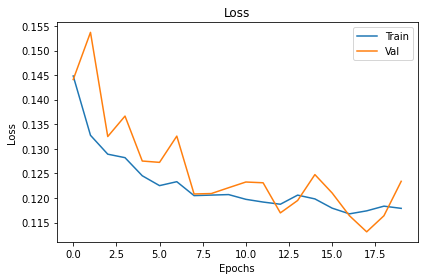

Max validation mae: 0.15368734300136566
Test loss : 0.11313
Test metric Loss (MAE) : 0.26245


In [13]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # print(x.shape, out.shape, out.contiguous().shape)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out[:, -1, :].view(-1, self.hidden_size)
        out = self.fc(out)
        return out

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

rnn = RNN(14, 32, 1)
rnn_Trainer = Trainer(train_gen720, val_gen720, rnn, 0.001, 'rnn')
fit(rnn_Trainer, 20)

plot_history(rnn_Trainer.history)

rnn_Trainer.evaluate_loader(test_gen720)

Epoch : 0
Training loss : 0.14612
Validation loss : 0.13892
Validation metric Loss : 0.29095
Epoch : 1
Training loss : 0.13522
Validation loss : 0.13063
Validation metric Loss : 0.28103
Epoch : 2
Training loss : 0.12796
Validation loss : 0.12553
Validation metric Loss : 0.27708
Epoch : 3
Training loss : 0.12242
Validation loss : 0.11973
Validation metric Loss : 0.27239
Epoch : 4
Training loss : 0.11820
Validation loss : 0.12069
Validation metric Loss : 0.27252
Epoch : 5
Training loss : 0.11599
Validation loss : 0.11517
Validation metric Loss : 0.26576
Epoch : 6
Training loss : 0.11577
Validation loss : 0.12011
Validation metric Loss : 0.27130
Epoch : 7
Training loss : 0.11490
Validation loss : 0.11429
Validation metric Loss : 0.26562
Epoch : 8
Training loss : 0.11500
Validation loss : 0.10847
Validation metric Loss : 0.25910
Epoch : 9
Training loss : 0.11325
Validation loss : 0.11757
Validation metric Loss : 0.26787
Epoch : 10
Training loss : 0.11491
Validation loss : 0.10631
Validatio

<Figure size 720x360 with 0 Axes>

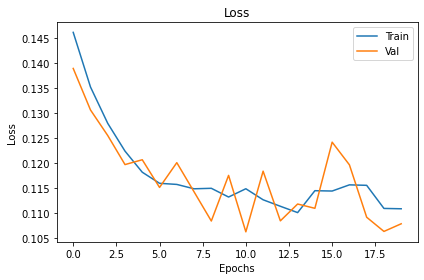

Max validation mae: 0.1389201134443283
Test loss : 0.10631
Test metric Loss (MAE) : 0.25607


In [14]:
rnn = RNN(14, 32, 1)
rnn_Trainer = Trainer(train_gen1440, val_gen1440, rnn, 0.001, 'rnn')
fit(rnn_Trainer, 20)

plot_history(rnn_Trainer.history)

rnn_Trainer.evaluate_loader(test_gen1440)

### GRU

Epoch : 0
Training loss : 0.13687
Validation loss : 0.13589
Validation metric Loss : 0.28892
Epoch : 1
Training loss : 0.11407
Validation loss : 0.13859
Validation metric Loss : 0.29078
Epoch : 2
Training loss : 0.10033
Validation loss : 0.12183
Validation metric Loss : 0.27500
Epoch : 3
Training loss : 0.08748
Validation loss : 0.09067
Validation metric Loss : 0.23663
Epoch : 4
Training loss : 0.07653
Validation loss : 0.08125
Validation metric Loss : 0.22501
Epoch : 5
Training loss : 0.06788
Validation loss : 0.07041
Validation metric Loss : 0.20891
Epoch : 6
Training loss : 0.06151
Validation loss : 0.06606
Validation metric Loss : 0.20250
Epoch : 7
Training loss : 0.05692
Validation loss : 0.05815
Validation metric Loss : 0.19052
Epoch : 8
Training loss : 0.05355
Validation loss : 0.07523
Validation metric Loss : 0.20944
Epoch : 9
Training loss : 0.05075
Validation loss : 0.05171
Validation metric Loss : 0.17882
Epoch : 10
Training loss : 0.04850
Validation loss : 0.06216
Validatio

<Figure size 720x360 with 0 Axes>

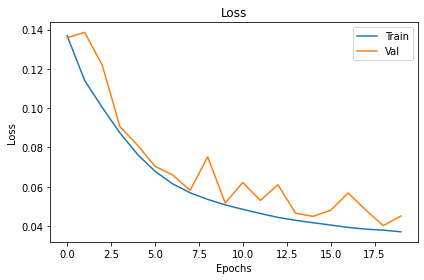

Max validation mae: 0.1385927051305771
Test loss : 0.04021
Test metric Loss (MAE) : 0.15763


In [15]:
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size

        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        # print(x.shape, out.shape, out.contiguous().shape)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out[:, -1, :].view(-1, self.hidden_size)
        out = self.fc(out)
        return out

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

gru = GRU(14, 32, 1)
gru_Trainer = Trainer(train_gen720, val_gen720, gru, 0.001, 'gru')
fit(gru_Trainer, 20)

plot_history(gru_Trainer.history)

gru_Trainer.evaluate_loader(test_gen720)

Epoch : 0
Training loss : 0.13565
Validation loss : 0.11804
Validation metric Loss : 0.26958
Epoch : 1
Training loss : 0.11013
Validation loss : 0.10246
Validation metric Loss : 0.25204
Epoch : 2
Training loss : 0.09405
Validation loss : 0.08667
Validation metric Loss : 0.23192
Epoch : 3
Training loss : 0.08298
Validation loss : 0.07743
Validation metric Loss : 0.21944
Epoch : 4
Training loss : 0.07424
Validation loss : 0.07488
Validation metric Loss : 0.21407
Epoch : 5
Training loss : 0.06737
Validation loss : 0.06285
Validation metric Loss : 0.19641
Epoch : 6
Training loss : 0.06188
Validation loss : 0.06344
Validation metric Loss : 0.19727
Epoch : 7
Training loss : 0.05736
Validation loss : 0.05715
Validation metric Loss : 0.18643
Epoch : 8
Training loss : 0.05395
Validation loss : 0.05298
Validation metric Loss : 0.18036
Epoch : 9
Training loss : 0.05097
Validation loss : 0.04911
Validation metric Loss : 0.17291
Epoch : 10
Training loss : 0.04856
Validation loss : 0.04679
Validatio

<Figure size 720x360 with 0 Axes>

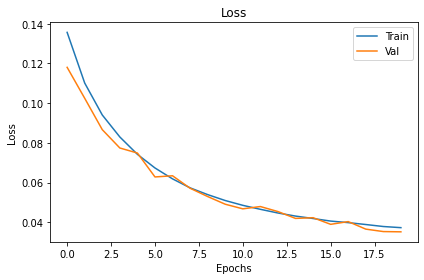

Max validation mae: 0.11804373562335968
Test loss : 0.03521
Test metric Loss (MAE) : 0.14609


In [16]:
gru = GRU(14, 32, 1)
gru_Trainer = Trainer(train_gen1440, val_gen1440, gru, 0.001, 'gru')
fit(gru_Trainer, 20)

plot_history(gru_Trainer.history)

gru_Trainer.evaluate_loader(test_gen1440)

### LSTM

Epoch : 0
Training loss : 0.13707
Validation loss : 0.12860
Validation metric Loss : 0.27798
Epoch : 1
Training loss : 0.11178
Validation loss : 0.11417
Validation metric Loss : 0.26351
Epoch : 2
Training loss : 0.09557
Validation loss : 0.08976
Validation metric Loss : 0.23499
Epoch : 3
Training loss : 0.08314
Validation loss : 0.07717
Validation metric Loss : 0.21676
Epoch : 4
Training loss : 0.07459
Validation loss : 0.07124
Validation metric Loss : 0.20791
Epoch : 5
Training loss : 0.06677
Validation loss : 0.06117
Validation metric Loss : 0.19258
Epoch : 6
Training loss : 0.06023
Validation loss : 0.05937
Validation metric Loss : 0.18988
Epoch : 7
Training loss : 0.05634
Validation loss : 0.06272
Validation metric Loss : 0.19400
Epoch : 8
Training loss : 0.05168
Validation loss : 0.07366
Validation metric Loss : 0.20588
Epoch : 9
Training loss : 0.04822
Validation loss : 0.06778
Validation metric Loss : 0.19991
Epoch : 10
Training loss : 0.04599
Validation loss : 0.04497
Validatio

<Figure size 720x360 with 0 Axes>

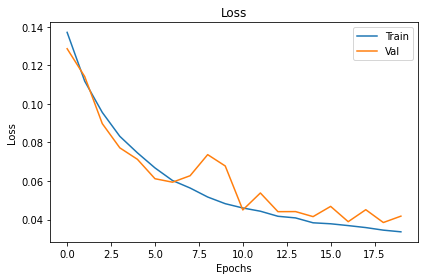

Max validation mae: 0.1286005824804306
Test loss : 0.03845
Test metric Loss (MAE) : 0.15197


In [17]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        (h0, c0) = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (h0, c0) = self.rnn(x, (h0, c0))

        # print(x.shape, out.shape, out.contiguous().shape)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out[:, -1, :].view(-1, self.hidden_size)
        out = self.fc(out)
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), 
                torch.zeros(1, batch_size, self.hidden_size).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

lstm = LSTM(14, 32, 1)
lstm_Trainer = Trainer(train_gen720, val_gen720, lstm, 0.001, 'lstm')
fit(lstm_Trainer, 20)

plot_history(lstm_Trainer.history)

lstm_Trainer.evaluate_loader(test_gen720)

Epoch : 0
Training loss : 0.13265
Validation loss : 0.11414
Validation metric Loss : 0.26483
Epoch : 1
Training loss : 0.10773
Validation loss : 0.10394
Validation metric Loss : 0.25406
Epoch : 2
Training loss : 0.09358
Validation loss : 0.08493
Validation metric Loss : 0.22910
Epoch : 3
Training loss : 0.08250
Validation loss : 0.07653
Validation metric Loss : 0.21681
Epoch : 4
Training loss : 0.07385
Validation loss : 0.07157
Validation metric Loss : 0.20906
Epoch : 5
Training loss : 0.06733
Validation loss : 0.06908
Validation metric Loss : 0.20533
Epoch : 6
Training loss : 0.06149
Validation loss : 0.07000
Validation metric Loss : 0.20430
Epoch : 7
Training loss : 0.05728
Validation loss : 0.05493
Validation metric Loss : 0.18173
Epoch : 8
Training loss : 0.05371
Validation loss : 0.04922
Validation metric Loss : 0.17341
Epoch : 9
Training loss : 0.05035
Validation loss : 0.04867
Validation metric Loss : 0.17263
Epoch : 10
Training loss : 0.04812
Validation loss : 0.04654
Validatio

<Figure size 720x360 with 0 Axes>

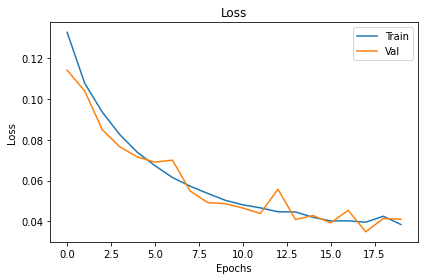

Max validation mae: 0.11413563042879105
Test loss : 0.03488
Test metric Loss (MAE) : 0.14591


In [18]:
lstm = LSTM(14, 32, 1)
lstm_Trainer = Trainer(train_gen1440, val_gen1440, lstm, 0.001, 'lstm')
fit(lstm_Trainer, 20)

plot_history(lstm_Trainer.history)

lstm_Trainer.evaluate_loader(test_gen1440)